In [1]:
%matplotlib inline
from keras.models import Sequential, Model
from keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, ELU, BatchNormalization, Lambda, merge, MaxPooling2D, Input, Activation
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.utils.visualize_util import plot
from keras.optimizers import Adam
from keras.callbacks import Callback, RemoteMonitor
import keras.backend as K


import pandas as pd 
import matplotlib.pyplot as plt
import cv2
import random
import numpy as np
import json

Using TensorFlow backend.


In [2]:
drive_log_df = pd.read_csv('data/driving_log.csv')
drive_log_df.head()

,center,left,right,steering,throttle,brake,speed
0,IMG/center_2016_12_01_13_30_48_287.jpg,IMG/left_2016_12_01_13_30_48_287.jpg,IMG/right_2016_12_01_13_30_48_287.jpg,0.0,0.0,0.0,22.148290
1,IMG/center_2016_12_01_13_30_48_404.jpg,IMG/left_2016_12_01_13_30_48_404.jpg,IMG/right_2016_12_01_13_30_48_404.jpg,0.0,0.0,0.0,21.879630
2,IMG/center_2016_12_01_13_31_12_937.jpg,IMG/left_2016_12_01_13_31_12_937.jpg,IMG/right_2016_12_01_13_31_12_937.jpg,0.0,0.0,0.0,1.453011
3,IMG/center_2016_12_01_13_31_13_037.jpg,IMG/left_2016_12_01_13_31_13_037.jpg,IMG/right_2016_12_01_13_31_13_037.jpg,0.0,0.0,0.0,1.438419
4,IMG/center_2016_12_01_13_31_13_177.jpg,IMG/left_2016_12_01_13_31_13_177.jpg,IMG/right_2016_12_01_13_31_13_177.jpg,0.0,0.0,0.0,1.418236


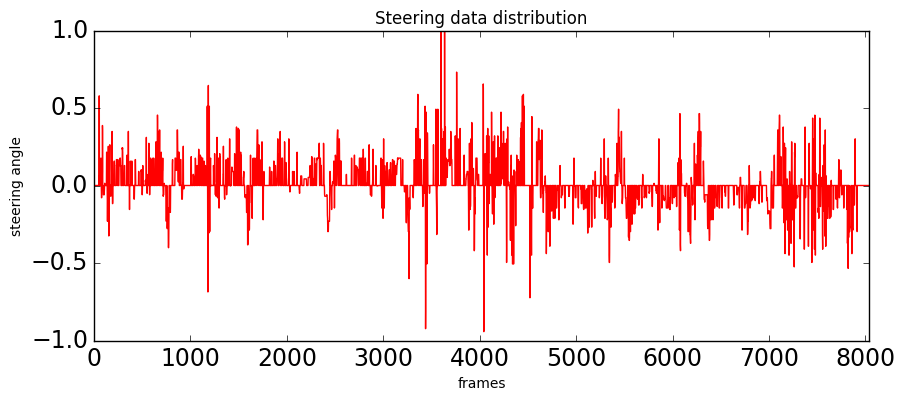

In [3]:
drive_log_df.steering.plot(title='Steering data distribution', fontsize=17, figsize=(10,4), color= 'r')
plt.xlabel('frames')
plt.ylabel('steering angle')
plt.show()

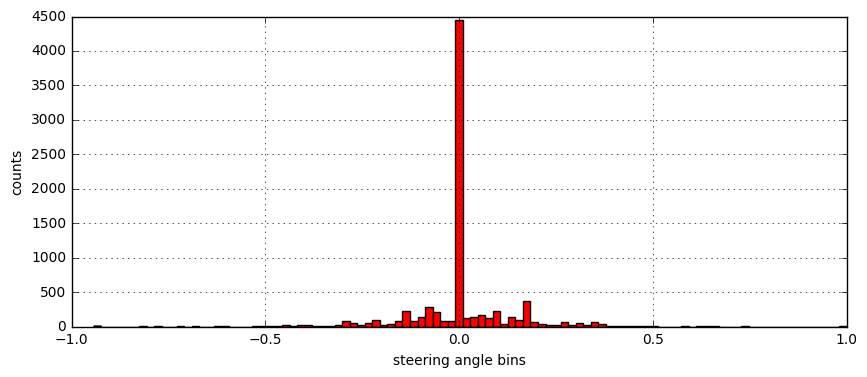

Dataset Size:  8036


In [4]:
plt.figure(figsize=(10,4))
drive_log_df.steering.hist(bins=100, color='r')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Dataset Size: ", len(drive_log_df.steering))

# The histogram above shows the dataset is unbalanced.
We will now go ahead and drop most of the zero steering angles, which correspond to mostly straight driving.

In [5]:
zero_steering = drive_log_df[drive_log_df.steering == 0].sample(frac=0.9)
drive_log_df = drive_log_df.drop(zero_steering.index)

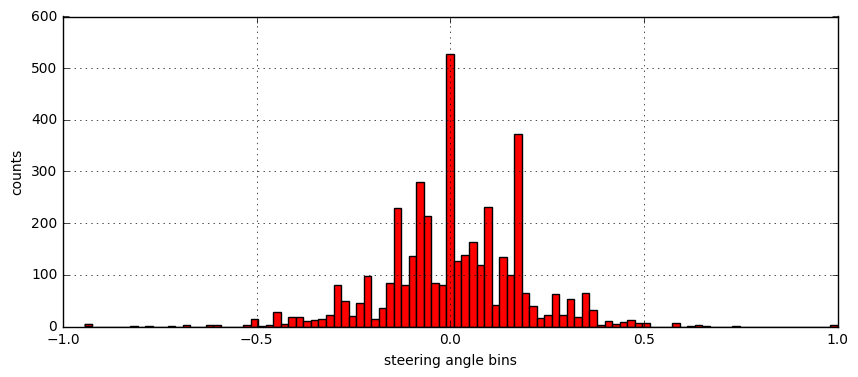

Current Dataset Size:  4111


In [6]:
plt.figure(figsize=(10,4))
drive_log_df.steering.hist(bins=100, color='r')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(drive_log_df.steering))

## Now we start making changes to the driver log file and we create a new driver log file.
This new driver log file is created to later support larger datasets by adding more 'meta' columns with augmentation information. You'll notice that each augmentation method adds the columns it needs to later augment the image when loaded.

In [7]:
def update_left_right_steering_correction(df):
    records = []
    for index, row in df.iterrows():
        left = row.left
        center = row.center
        right = row.right
        steering = row.steering
        
        records.append({
            'image': left,
            'steering': steering + 0.23
        })
        
        records.append({
            'image': right,
            'steering': steering - 0.23
        })
        
        records.append({
            'image': center,
            'steering': steering
        })
    
    return pd.DataFrame(data=records, columns=['image', 'steering'])

new_drive_log = update_left_right_steering_correction(drive_log_df)
new_drive_log.tail()

,image,steering
12328,IMG/right_2016_12_01_13_46_38_700.jpg,-0.23
12329,IMG/center_2016_12_01_13_46_38_700.jpg,0.00
12330,IMG/left_2016_12_01_13_46_38_846.jpg,0.23
12331,IMG/right_2016_12_01_13_46_38_846.jpg,-0.23
12332,IMG/center_2016_12_01_13_46_38_846.jpg,0.00


### We sample (normal dist) 40% of example that are not zero angles; flip them and reverse steering angle.

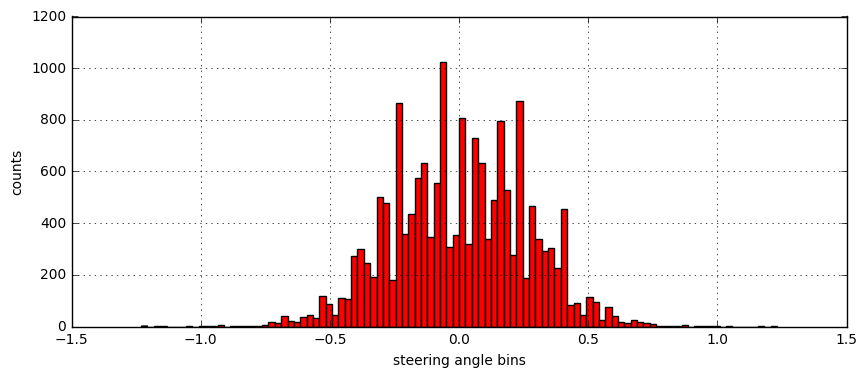

Current Dataset Size:  17092


In [8]:
def flip_images_augmentation(df):
    new_df = df[df.steering != 0].sample(frac=0.4)
    df.loc[:,'is_flipped'] = False
    new_df.loc[:,'is_flipped'] = True
    left_rows = (new_df.steering < 0)
    right_rows = (new_df.steering > 0)
    new_df.loc[left_rows,'steering'] = new_df[left_rows].steering.abs()
    new_df.loc[right_rows, 'steering'] = new_df[right_rows].steering * -1
    return pd.concat([df, new_df])

augmented = flip_images_augmentation(new_drive_log)
plt.figure(figsize=(10,4))
augmented.steering.hist(bins=100, color='r')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(augmented.steering))

### We have to upsample under represented example and we do this by shifting images and their corresponding angles

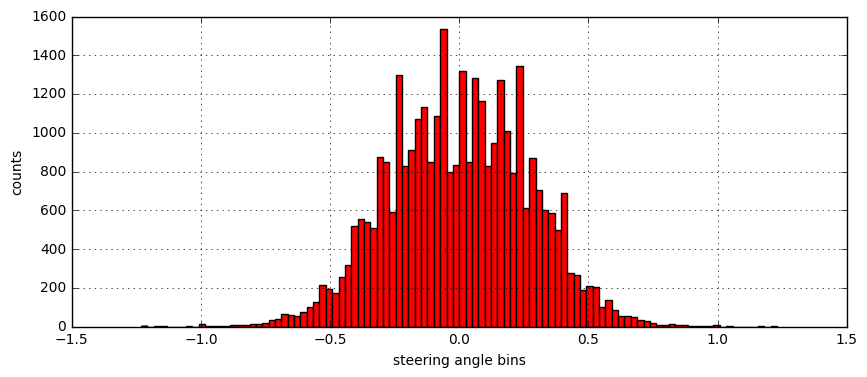

Current Dataset Size:  33748


In [9]:
def shift_img_augmentation(df):
    df.loc[:,'random_shift'] = 0
    new_df = df[df.steering != 0].copy()
    df.loc[:,'is_shift'] = False
    new_df.loc[:,'is_shift'] = True
    
    
    max_shift = 30
    max_ang = 0.17
    
    def row_shift_update(row):
        random_shift = np.random.randint(-max_shift, max_shift + 1)
        row.random_shift = random_shift
        updated_steer = row.steering + (random_shift / max_shift) * max_ang
        if abs(updated_steer) > 1:
            updated_steer = -1 if (updated_steer < 0) else 1

        row.steering = updated_steer
        return row

    new_df = new_df.apply(row_shift_update, axis=1)
    return pd.concat([df, new_df])

shifted = shift_img_augmentation(augmented)
plt.figure(figsize=(10,4))
shifted.steering.hist(bins=100, color='r')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(shifted.steering))

shifted.tail(1)
plt.show()

### The histogram looks more balanced from the upsampling, but this caused us to created steering angles outside the bounds  of [-1,1]

#### The `process_driver_log()` method is used to pump out the final driver log file that we will use to generate the new driver log dataframe and also drops those examples. 

In [10]:
def process_driver_log(driver_log):
    update_log = update_left_right_steering_correction(driver_log)
    update_log = flip_images_augmentation(update_log)
    update_log = shift_img_augmentation(update_log)
    #update_log = change_brightness_augmentation(update_log)
    
    #reset index since we it's no longer good.
    update_log = update_log.reset_index(drop=True)
    
    #drop outbound steering examples to be between [-1,1] !
    outbound_steering = update_log[abs(update_log.steering) > 1]
    update_log = update_log.drop(outbound_steering.index)

    return update_log

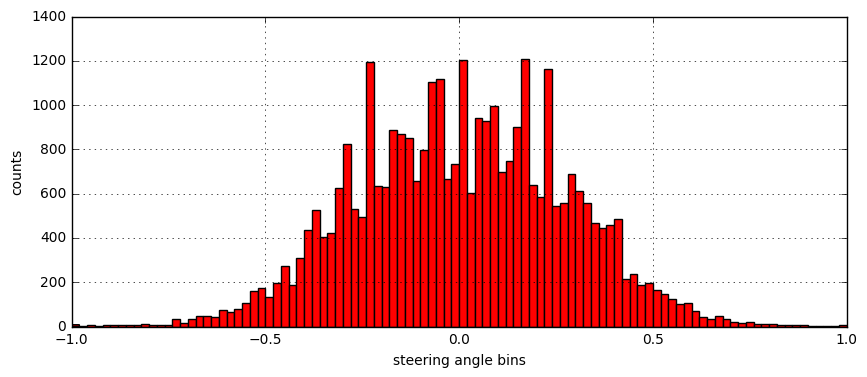

Current Dataset Size:  33738


In [11]:
processed_log = process_driver_log(drive_log_df)

plt.figure(figsize=(10,4))
processed_log.steering.hist(bins=100, color='r')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(processed_log.steering))


# Now the histogram is mostly evenly distributed and the question now becomes how much data can we trim and still train the model?!  
After some experimenting we can trim this histogram with 100 bins by trimming the bins with over 500 count.
The hacky solution I created below basically generates a list of strings that are panda dataframe masking code using the ranges from `np.histogram()` to search; then I loop through the list of code and run them through the eval() method to execute the code!
** The end result is no bins will go past 400 examples **

In [12]:
hist, counts = np.histogram(processed_log.steering, bins=100)
upper_limit = 400
over = [(i, v) for i, v in enumerate(hist) if v > upper_limit ]
over_ranges = [(counts[i],counts[i+1]) for i,_ in over]

#loop through ranges and create a mask for each bin 
masks = ["processed_log[(processed_log.steering >= {0}) & (processed_log.steering < {1})]".format(l,r) for l,r in over_ranges]

for mask in masks:
    selected = eval(mask)
    selected_length = len(selected)
    frac_to_drop = (selected_length-upper_limit)/selected_length
    samples_to_drop = selected.sample(frac=frac_to_drop)
    processed_log = processed_log.drop(samples_to_drop.index)

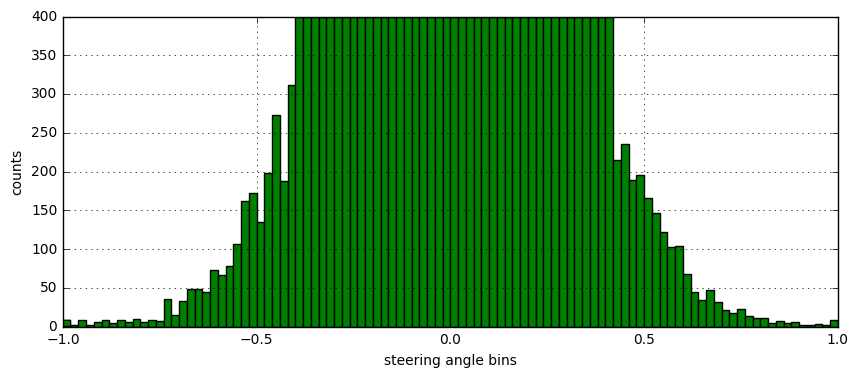

Current Dataset Size:  20311


In [13]:
plt.figure(figsize=(10,4))
processed_log.steering.hist(bins=100, color='g')
plt.xlabel('steering angle bins')
plt.ylabel('counts')
plt.show()
print("Current Dataset Size: ", len(processed_log.steering))


In [16]:
processed_log.to_csv('preprocessed_driver_log.csv')

# Now we have a decent starting point and we can start the pipeline process!!

## The first thing we want to do is reduce the input shape size.
We do this by first cropping the top and bottom from the image that would be noise to the model. Then we resize the image to (64,64) and convert to HSV and only returning the S channel. This takes us from (160,320,3) to (64, 64, 1)!!

(160, 320, 3)


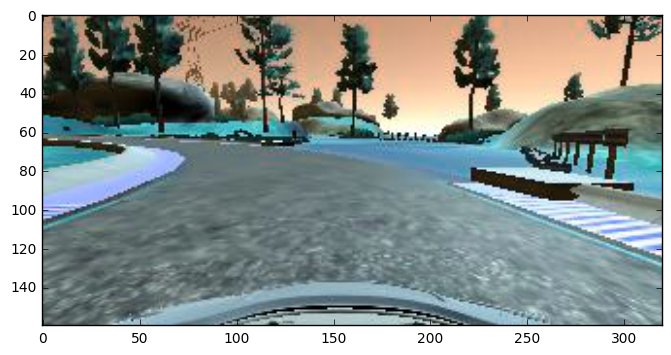

(64, 64)


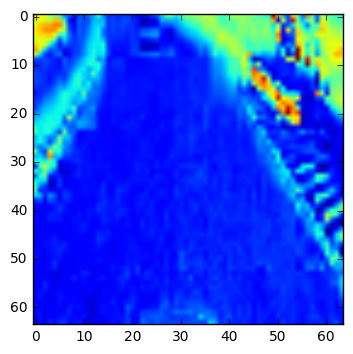

In [47]:
def crop_top_and_bottom(image):
    resized = cv2.resize(image[70:140], (64,64),  cv2.INTER_AREA)
    return cv2.cvtColor(resized, cv2.COLOR_RGB2HSV)[:,:,1]

plt.figure(figsize=(10,4))
random_image = drive_log_df.iloc[0]
image = cv2.imread("./data/{0}".format(random_image.center))
print(image.shape)
plt.figure(1)
plt.imshow(image)
plt.show()

cropped_image = crop_top_and_bottom(image)
print(cropped_image.shape)
plt.figure(2)
plt.imshow(cropped_image)
plt.show()

## Last step is to create the shift image and  load image methods.

Notice the `load_image()` method takes a dataframe row and uses the assumed meta columns to make the modification to the image on the fly. This assumes the preprocessing stage has added the columns needed.

In [48]:
def shift_img(image, random_shift):
    rows, cols = image.shape
    mat = np.float32([[1, 0, random_shift], [0, 1, 0]])
    return cv2.warpAffine(image, mat, (cols, rows))

def load_image(row):
    image = cv2.imread("./data/{0}".format(row.image.strip()))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = crop_top_and_bottom(image)
    
    if(row.is_flipped):
        image = cv2.flip(image,1)
    if(row.is_shift):
        image = shift_img(image, row.random_shift)  
    return image

## We can actually load everthing into memory and we don't need to use a generator! 

In [49]:
def load_all_features_and_labels(df):
    images = [load_image(row) for _, row in df.iterrows()]
    return np.array(images).reshape((len(images), 64, 64, 1)), df.steering 

In [50]:
features, labels = load_all_features_and_labels(processed_log)
print(features.shape, labels.shape)

(20354, 64, 64, 1) (20354,)


# We are now ready to go into creating our model!

### Main goals for us to think about while creating a model
1. Is it efficient for the task at hand?
2. If this was to be downloaded onto hardware in a car what would the power consumption and usuability be like?
    * There is an interesting paper called [Deep Compression](https://arxiv.org/abs/1510.00149), which we don't implement here but it is food for thought and shows that model can be tiny and still work!

I started with a modified comma.ai model and I had a successful model, but it needed 300,000 trainable parameters. Reading the Deep compression paper and a blog post titled [Self-driving car in a simulator with a tiny neural network](https://medium.com/@xslittlegrass/self-driving-car-in-a-simulator-with-a-tiny-neural-network-13d33b871234#.x1kdv5hgt) I quickly realized that we can do better. The blog post linked shows a 63 parameter model that uses tiny images and a small network to get a stable model. I wanted to experiment and see if I could make it smaller and still stable. The solution developed over a number of experiments is a modified [SqueezeNet](https://arxiv.org/abs/1602.07360) implementation. With a squeeze net you get three addtional hyperparameters that are used to generate the fire module:

1. S1x1: Number of 1x1 kernals to use in the squeeze layer within the fire module
2. E1x1: Number of 1x1 kernals to use in the expand layer within the fire module
3. E3x3: Number of 3x3 kernals to use in the expand layer within the fire module

#### Fire Module Zoomed In

<div align="center">
  <img src="./images/fire_module.png"><br><br>
</div>


In [61]:
def fire_module(x, fire_id, squeeze=16, expand=64):
    """
    This is a modified version of: https://github.com/rcmalli/keras-squeezenet/blob/master/squeezenet.py#L14
    Changes made:
    * Uses ELU activation
    * Only supports tf 
    """
    s_id = 'fire' + str(fire_id) + '/'
    c_axis = 3
    sq1x1 = "squeeze1x1"
    exp1x1 = "expand1x1"
    exp3x3 = "expand3x3"
    elu = "elu_"
  
    x = Convolution2D(squeeze, 1, 1, border_mode='valid', name=s_id + sq1x1)(x)
    x = Activation('elu', name=s_id + elu + sq1x1)(x)

    left = Convolution2D(expand, 1, 1, border_mode='valid', name=s_id + exp1x1)(x)
    left = Activation('elu', name=s_id + elu + exp1x1)(left)

    right = Convolution2D(expand, 3, 3, border_mode='same', name=s_id + exp3x3)(x)
    right = Activation('elu', name=s_id + elu + exp3x3)(right)

    x = merge([left, right], mode='concat', concat_axis=c_axis, name=s_id + 'concat')
    return x

def squeeze_model_10000():
    """
    This model is a modification from the reference:
    https://github.com/rcmalli/keras-squeezenet/blob/master/squeezenet.py
    
    Normalizing will be done in the model directly for GPU speedup 
    """
    input_shape=(64, 64, 1)
    input_img = Input(shape=input_shape)
    x = Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape)(input_img)
    
    x = Convolution2D(2, 3, 3, subsample=(2, 2), border_mode='valid', name='conv1')(x)
    x = Activation('elu', name='elu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=2, expand=6)
    x = fire_module(x, fire_id=3, squeeze=16, expand=64)
    x = Dropout(0.2, name='drop9')(x)

    x = GlobalAveragePooling2D()(x)
    out = Dense(1, name='loss')(x)
    model = Model(input=input_img, output=[out])
    plot(model, to_file='SqueezeNet10k.png', show_shapes=True)
    
    
    model.compile(optimizer=Adam(lr=1e-3), loss='mse')
    return model

def squeeze_model_1005():
    """
    This model is a modification from the reference:
    https://github.com/rcmalli/keras-squeezenet/blob/master/squeezenet.py
    
    Normalizing will be done in the model directly for GPU speedup 
    """
    input_shape=(64, 64, 1)
    input_img = Input(shape=input_shape)
    x = Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape)(input_img)
    
    x = Convolution2D(2, 3, 3, subsample=(2, 2), border_mode='valid', name='conv1')(x)
    x = Activation('elu', name='elu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=2, expand=6)
    x = fire_module(x, fire_id=3, squeeze=6, expand=12)
    x = Dropout(0.2, name='drop9')(x)


    x = GlobalAveragePooling2D()(x)
    out = Dense(1, name='loss')(x)
    model = Model(input=input_img, output=[out])
    plot(model, to_file='SqueezeNet1005.png', show_shapes=True)
    
    
    model.compile(optimizer=Adam(lr=1e-1), loss='mse')
    return model

def squeeze_model_329():
    """
    This model is a modification from the reference:
    https://github.com/rcmalli/keras-squeezenet/blob/master/squeezenet.py
    
    Normalizing will be done in the model directly for GPU speedup 
    """
    input_shape=(64, 64, 1)
    input_img = Input(shape=input_shape)
    x = Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape)(input_img)
    
    x = Convolution2D(2, 3, 3, subsample=(2, 2), border_mode='valid', name='conv1')(x)
    x = Activation('elu', name='elu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=2, expand=6)
    x = fire_module(x, fire_id=3, squeeze=2, expand=6)
    x = Dropout(0.2, name='drop9')(x)

    x = GlobalAveragePooling2D()(x)
    out = Dense(1, name='loss')(x)
    model = Model(input=input_img, output=[out])
    plot(model, to_file='SqueezeNet329.png', show_shapes=True)
    
    
    model.compile(optimizer=Adam(lr=1e-3), loss='mse')
    return model

def squeeze_model_159():
    """
    This model is a modification from the reference:
    https://github.com/rcmalli/keras-squeezenet/blob/master/squeezenet.py
    
    Normalizing will be done in the model directly for GPU speedup 
    """
    input_shape=(64, 64, 1)
    input_img = Input(shape=input_shape)
    x = Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape)(input_img)
    
    x = Convolution2D(1, 3, 3, subsample=(2, 2), border_mode='valid', name='conv1')(x)
    x = Activation('elu', name='elu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=2, expand=6)
    x = Dropout(0.2, name='drop9')(x)


    x = GlobalAveragePooling2D()(x)
    out = Dense(1, name='loss')(x)
    model = Model(input=input_img, output=[out])
    plot(model, to_file='SqueezeNet159.png', show_shapes=True)
    
    
    model.compile(optimizer=Adam(lr=1e-1), loss='mse')
    return model

def squeeze_model_63():
    """
    This model is a modification from the reference:
    https://github.com/rcmalli/keras-squeezenet/blob/master/squeezenet.py
    
    Normalizing will be done in the model directly for GPU speedup 
    """
    input_shape=(64, 64, 1)
    input_img = Input(shape=input_shape)
    x = Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape)(input_img)
    
    x = Convolution2D(1, 3, 3, subsample=(2, 2), border_mode='valid', name='conv1')(x)
    x = Activation('elu', name='elu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=2, expand=2)
    x = Dropout(0.2, name='drop9')(x)


    x = GlobalAveragePooling2D()(x)
    out = Dense(1, name='loss')(x)
    model = Model(input=input_img, output=[out])
    plot(model, to_file='SqueezeNet63.png', show_shapes=True)
    
    
    model.compile(optimizer=Adam(lr=1e-1), loss='mse')
    return model

def squeeze_model_52():
    """
    This model is a modification from the reference:
    https://github.com/rcmalli/keras-squeezenet/blob/master/squeezenet.py
    
    Normalizing will be done in the model directly for GPU speedup 
    """
    input_shape=(64, 64, 1)
    input_img = Input(shape=input_shape)
    x = Lambda(lambda x: x/127.5 - 1.,input_shape=input_shape)(input_img)
    
    x = Convolution2D(2, 3, 3, subsample=(2, 2), border_mode='valid', name='conv1')(x)
    x = Activation('elu', name='elu_conv1')(x)
    x = MaxPooling2D(pool_size=(3, 3), strides=(2, 2), name='pool1')(x)

    x = fire_module(x, fire_id=2, squeeze=1, expand=2)
    x = Dropout(0.2, name='drop3')(x)


    x = GlobalAveragePooling2D()(x)
    out = Dense(1, name='loss')(x)
    model = Model(input=input_img, output=[out])
    plot(model, to_file='SqueezeNet52.png', show_shapes=True)
    
    
    model.compile(optimizer=Adam(lr=1e-1), loss='mse')
    return model

In [62]:
model = squeeze_model_52()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_8 (InputLayer)             (None, 64, 64, 1)     0                                            
____________________________________________________________________________________________________
lambda_8 (Lambda)                (None, 64, 64, 1)     0           input_8[0][0]                    
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 31, 31, 2)     20          lambda_8[0][0]                   
____________________________________________________________________________________________________
elu_conv1 (Activation)           (None, 31, 31, 2)     0           conv1[0][0]                      
___________________________________________________________________________________________

## Here is the final 52 param model that we are using for this project.
<div align="left">
  </br>
  <img src="./images/SqueezeNet52.png"><br><br>
</div>

### Through some experiments I know that once the loss reach around .03 we have a model that can drive in the simulator so we use a custom early termination callback to stop the training!

In [59]:
class CustomEarlyStop(Callback):
    """
    Custom Callback that stops the epoch when val_loss reachs 0.3
    This callback assumes you are logging val loss
    """
    def __init__(self, monitor='val_loss'):
        super(CustomEarlyStop, self).__init__()
        self.monitor = monitor
        
   
    def on_epoch_end(self, epoch, logs=None):
        val_loss = logs.get(self.monitor)
        if val_loss <= 0.039:
            print("\nEarly Stop on Epoch {0} with Val_loss {1}\n".format(epoch,val_loss))
            self.model.stop_training = True

# To run the model training below you'll need to download and run the vis tool

### Simply do the following:
1. git clone https://github.com/fchollet/hualos
2. cd into the directory
3. run `python api.py`
4. visit localhost:9000
5. run the training below and it'll produce the loss plot you see below!

#### Click [RemoteMonitor](https://keras.io/callbacks/#remotemonitor) for more information on how this callback works!

In [63]:
#This is a callback that works with https://github.com/fchollet/hualos and gives you simple vis of the training loss
remote = RemoteMonitor(headers=None)
early_stop = CustomEarlyStop(monitor='val_loss')

h = model.fit(x=features,y=labels,verbose=1,batch_size=128,nb_epoch=50,validation_split=0.3, callbacks=[remote, early_stop])

Train on 14247 samples, validate on 6107 samples
Epoch 1/50
14247/14247 [==============================] - 7s - loss: 0.1025 - val_loss: 0.1052
Epoch 2/50
14247/14247 [==============================] - 7s - loss: 0.0984 - val_loss: 0.1072
Epoch 3/50
14247/14247 [==============================] - 7s - loss: 0.0986 - val_loss: 0.1091
Epoch 4/50
14247/14247 [==============================] - 7s - loss: 0.0995 - val_loss: 0.1145
Epoch 5/50
14247/14247 [==============================] - 7s - loss: 0.0988 - val_loss: 0.1194
Epoch 6/50
14247/14247 [==============================] - 7s - loss: 0.0986 - val_loss: 0.1211
Epoch 7/50
14247/14247 [==============================] - 7s - loss: 0.0990 - val_loss: 0.1173
Epoch 8/50
14247/14247 [==============================] - 7s - loss: 0.0991 - val_loss: 0.1103
Epoch 9/50
14208/14247 [============================>.] - ETA: 0s - loss: 0.0639
Early Stop on Epoch 8 with Val_loss 0.03719138181615094

14247/14247 [==============================] - 7s - l

## Notice the loss doesn't change greatly and because we use an aggressive learning rate we could benefit from early termination.

This model was tiny (52 params!) and we are training it on a 2012 macbook air; looks like we could stop early and we could do this by writing our own keras callback to monitor and early terminate specifically for the val_loss ~0.3!
** Note: this is from a previous run without early termination **

<div align="left">
  </br>
  <img src="./images/loss_plot.png"><br><br>
</div>

In [64]:
filename = 'model'#"squeezemodel{0}".format(squeezemodel.count_params())
model.save_weights(filename+".h5", True)

with open(filename+'.json', 'w') as outfile:
    json.dump(model.to_json(), outfile)
    
print("Saved model weights and configuration")

Saved model weights and configuration


# Congrats we are done!